In [124]:
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold,StratifiedKFold

In [97]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
import rasterio
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [100]:
df = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')
test.head(3)
# Sample submission:
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,ID,Label
0,00MZGKU,0
1,015JA41,0
2,01POB64,0


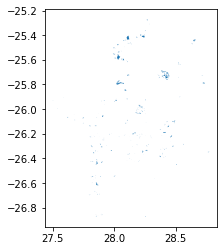

In [4]:
gp = gpd.read_file('GP_Informal_settlement2017.shp')
gp.plot()

In [54]:
from shapely.geometry import Polygon, Point
lats = []
lons = []
labels = []
for i in tqdm(range(300000)):
    lon = 28 + random.random()*0.5
    lat = -26 + random.random()*0.5
    p = Point(lon, lat)
    IN = False
    for geom in gp.geometry:
        if p.within(geom):
            IN = True
    lats.append(lat)
    lons.append(lon)
    labels.append(IN)
ls = pd.DataFrame({
    'LAT':lats,
    'LON':lons,
    'Label':labels
})
ls.sample(10)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,LAT,LON,Label
153083,-25.642516,28.238717,False
162546,-25.531481,28.227405,False
186694,-25.562871,28.077313,False
163280,-25.856449,28.173630,False
226322,-25.729787,28.451814,False
74278,-25.730783,28.495257,False
111481,-25.677179,28.048909,False
68255,-25.757738,28.110121,False
265236,-25.995761,28.287272,False
124551,-25.778753,28.489450,False


In [55]:
ls.Label.value_counts()

False    296405
True       3595
Name: Label, dtype: int64

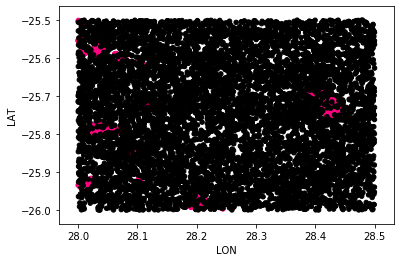

In [105]:
l_sample = pd.concat([ls.loc[ls.Label==True], ls.loc[ls.Label==False].sample(frac=0.025)])
l_sample.plot(kind='scatter', x='LON', y='LAT', c=l_sample['Label'].map(lambda x: (1, 0, 0.5) if x else (0, 0, 0)))

In [106]:
df['Label'].value_counts()/df.shape[0]

False    0.744452
True     0.255548
Name: Label, dtype: float64

In [107]:
l_sample.shape

(11005, 3)

In [108]:
l_sample.Label.value_counts()/l_sample.shape[0]

False    0.67333
True     0.32667
Name: Label, dtype: float64

In [109]:
l_sample['ID']='ID'+l_sample.index.astype(str)

In [110]:
df=pd.concat([df,l_sample])
df.shape

(15286, 4)

In [111]:
df.Label.value_counts()

False    10597
True      4689
Name: Label, dtype: int64

In [119]:
dataset = rasterio.open('2528C.tif') 
# Load bands into RAM
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)
# Load bands into RAM

# # Let's do 5 points for now - use df.values to do this for the whole dataset
for ID, lat, lon, label in df.sample(2).values:
    
    # Blank image
    im = np.zeros((200,200,3), np.uint8)
    
    # Get pixel coords
    row, col = dataset.index(lon, lat)
    
    # Add image data
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    # Save with the location in the name
    im = Image.fromarray(im)
    pth = 'small_images/negative/'
    if label == True:
        pth = 'small_images/positive/'
    im.save(pth+f"im_{ID}_{lat}_{lon}.jpeg")

In [120]:
bad_IDs = []
for i,x in df.iterrows():
    row, col = dataset.index(x['LON'],x['LAT'])
    if band[row-100:row+100, col-100:col+100].shape != (200,200):
#         print(lon,lat)
        bad_IDs.append(x['ID'])

In [121]:
df = df[~df['ID'].isin(list(set(bad_IDs)))]

In [122]:
df['Label'].value_counts()

False    10500
True      4680
Name: Label, dtype: int64

In [123]:
# Get the image:
# random_seed(42)
def get_x(ID):
    row = df.loc[df.ID == ID]
    lat, lon = row['LAT'].values[0], row['LON'].values[0]
    im = np.zeros((200,200,3), np.uint8)
    row, col = dataset.index(lon, lat)
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    return im

# And the label
def get_y(ID):
    row = df.loc[df.ID == ID]
    return int(row['Label'].values[0])

# Get the list of Image IDS:
def get_im_ids(path):
    return df.ID.values


def get_data(fold_id,folds,size,bs):
# test_img = ImageList.from_df(test_df, path=data_folder, folder='images')
    tfms = [Rotate(4),Flip(),Brightness(0.5,p=0.25),Zoom(max_zoom=1.1,p=0.25)]
    # And build the datablock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_im_ids,
        get_x=get_x,
        get_y=get_y, 
        splitter=KFSplitter(fold_id=fold_id,folds=folds),
        batch_tfms=tfms,
        item_tfms=[Resize(size)]
    )
    dls = dblock.dataloaders(Path(''), bs=bs)
    return dls


In [127]:
path = Path('./small_images/')
bs = 64
kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=range_of(get_image_files(path))))
len(folds)
# folds

10

In [128]:
def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

In [131]:
dls = get_data(fold_id=0,folds=folds,size=224,bs=16)

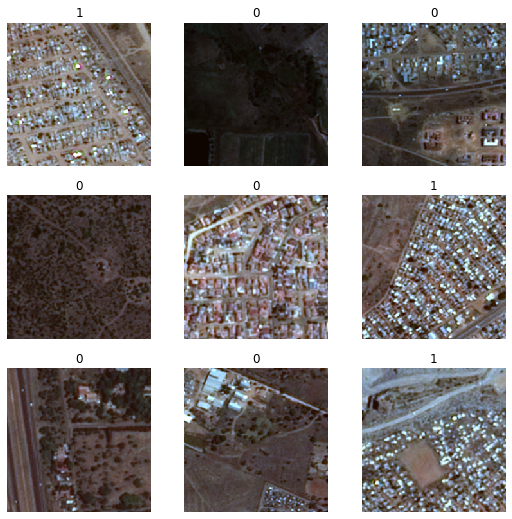

In [132]:
dls.show_batch()

In [134]:

for fold_id in range(kf):
    print(f'Running Fold-{fold_id}')
    dls = dls = get_data(fold_id=fold_id,folds=folds,size=200,bs=16)
    learn = cnn_learner(dls, resnet34, metrics=[error_rate,accuracy])
    learn.fine_tune(1)
    learn.save(f'model-{fold_id}')

Running Fold"-0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.193370,0.147094,0.044796,0.955204,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.110061,0.072585,0.027668,0.972332,02:51


Running Fold"-1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.228917,0.131058,0.043149,0.956851,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.144766,0.057053,0.020751,0.979249,02:50


Running Fold"-2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.243241,0.118956,0.044796,0.955204,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.107718,0.070819,0.024374,0.975626,02:50


Running Fold"-3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.204507,0.118268,0.040843,0.959157,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.137353,0.064729,0.020751,0.979249,02:50


Running Fold"-4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.218521,0.150370,0.049078,0.950922,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.096641,0.069062,0.024704,0.975296,02:50


Running Fold"-5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.218913,0.120605,0.044466,0.955534,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.107150,0.070693,0.026021,0.973979,02:50


Running Fold"-6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.228749,0.167018,0.063900,0.936100,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.112325,0.056312,0.019763,0.980237,02:52


Running Fold"-7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.204127,0.131328,0.042161,0.957839,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.121354,0.064160,0.024704,0.975296,02:52


Running Fold"-8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.224889,0.125928,0.044137,0.955863,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.109111,0.061318,0.019763,0.980237,02:52


Running Fold"-9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.228722,0.124045,0.042161,0.957839,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.092822,0.052111,0.017787,0.982213,02:51


In [136]:
test = pd.read_csv('Test.csv')
test.head(3)

,ID,LAT,LON
0,00MZGKU,-29.8920,30.8575
1,015JA41,-29.8905,30.8705
2,01POB64,-29.9615,30.8950


In [137]:
dataset = rasterio.open('2930D.tif') # We'll use rasterio for all raster operations

In [138]:
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [139]:
test['Label']=0
df=pd.concat([df,test])

In [140]:
idx = test['ID'].values
tdl = learn.dls.test_dl(idx)

In [141]:
# tdl = learn.dls.test_dl(idx)


In [147]:

def get_k_fold_preds(kf):
    preds = []
    for fold_id in tqdm(range(kf)):
        learn.load(f'model-{fold_id}')
        test_preds = array(learn.tta(dl=tdl)[0][:,1])
        preds.append(test_preds)
        
    return preds

In [148]:
ttapreds = get_k_fold_preds(kf)

In [143]:
preds = get_k_fold_preds(kf)

In [149]:
np.mean(ttapreds,0)

array([0.02177821, 0.0583695 , 0.13312754, ..., 0.6545969 , 0.11136861,
       0.00750613], dtype=float32)

In [152]:
test['Label']=np.mean(ttapreds,0)
test

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.021778
1,015JA41,-29.8905,30.8705,0.058369
2,01POB64,-29.9615,30.8950,0.133128
3,02125F8,-29.9660,30.8500,0.019030
4,03E8VFF,-29.9080,30.8760,0.101497
...,...,...,...,...
2608,ZXTOTE4,-29.9390,30.8770,0.006513
2609,ZZ37046,-29.9675,30.8730,0.382743
2610,ZZKO0HF,-29.9755,30.9050,0.654597
2611,ZZQN3L6,-29.9115,30.8625,0.111369


In [153]:
sum(test['Label']>0.5)

249

In [154]:
test[['ID','Label']].to_csv('Zindi_sub_22_kf10.csv',index=False)

In [155]:
test['Label'].describe()

count    2613.000000
mean        0.186880
std         0.203961
min         0.000363
25%         0.028298
50%         0.112476
75%         0.282535
max         0.980114
Name: Label, dtype: float64